###### <img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predicting Presence of West Nile Virus <br>
**Notebook 2: Data Pre-Processing I**

# TABLE OF CONTENTS

**1a. EDA on Training Dataset** <br>
**1b. EDA on Weather Dataset** <br>
**1c. EDA on Spray Dataset** <br>
**2. Data Preprocessing I (This Notebook)** <br>
- [(1) Removal of 'NumMosquitos'](#(1)-Removal-of-"NumMosquitos") <br>
- [(2) Removal of extra trap characters](#(2)-Removal-of-extra-trap-characters) <br>
- [(3) Understanding Timeline of Data Available](#(3)-Understanding-Timeline-of-Data-Available) <br>
- [(4) Streamlining of Available Information](#(3)-Streamlining-of-Available-Information) <br>
- [(5) Removing Correlated Weather Data](#(5)-Removing-Correlated-Weather-Data) <br>
- [(6) On Weather Information by both Weather Stations](#(6)-On-Weather-Information-by-both-Weather-Stations) <br>
- [(7) Export Datasets for Further Modelling](#(7)-Export-Datasets-for-Further-Modelling) <br>

**3. Data Preprocessing II** <br>
**4a. Modelling (Pycaret)** <br>
**4b. Modelling** <br>
**5. Cost Benefit Analysis** <br>
**6. Conclusion & Recommendations** <br>

In [1]:
import pandas as pd
import numpy as np

# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# For distance measuring given lat long
import geopy.distance

# for apply progress tracking
from tqdm import tqdm
tqdm.pandas()

train = pd.read_csv('./assets/train.csv')
test = pd.read_csv('./assets/test.csv')
weather = pd.read_csv('./assets/weather.csv')
spray = pd.read_csv('./assets/spray.csv')

In [2]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing Part I

In [3]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


## (1) Removal of "NumMosquitos"

We also have a column in train dataset 'NumMosquitos' that is not found in the test set. Let's remove this column. The NumMosquitos can supposedly capture the extent of mosquitos traffic at a specific area. In the absence of such data in the test set, we believed that said information is also effectively captured through the dummification of the 'Trap' variable (i.e. the factors - including mosquitos traffic, that are unique to each trap's location). We therefore do not see a need to maintain this column.

In [4]:
train.drop(columns = ['NumMosquitos'], inplace = True)

## (2) Removal of extra trap characters

Satellite traps deployed in the same proximity are given a suffix in addition to their parent trap's name (e.g. T200A is a satellite of T200). Physically, the satellite are placed about 300m to 400m away from the parent satellite. There exists a couple of issues: (1) Certain satellites encountered in the test set were not present in the train set, and (2) The additional list of satellite traps builds onto an already extensive list of traps used in this study (which creates a number of variables in our final model). 

In addressing this, we sought to simplify the satellite traps by **defaulting them to their parent satellite**. In implementation, we will remove the extra suffix of these satellite traps so that the characteristics (i.e. as captured in the dummy variable the model will create for each trap) will not be differentiated from those of their parents*. This will foremost ease the issue of encountering unseen satellite traps in test set, while reducing the dimensionality of our model.

_A later segment will also see us changing the coordinates (Longitude and Latitude) of each satellite trap to be the same that of their parent. With each satellite being about 300 to 400m away from their parents, the adjustment is not expected to affect the results in any significant ways._

In [5]:
# list of satellite traps in test not seen in train set
[trap for trap in test['Trap'].unique() if trap not in train['Trap'].unique()]

['T090A',
 'T090B',
 'T090C',
 'T200A',
 'T128A',
 'T200B',
 'T218A',
 'T218C',
 'T218B',
 'T002A',
 'T002B',
 'T234',
 'T065A']

In [6]:
# actual code to remove suffix of satellite traps for train set
train['Trap'] = train.progress_apply(lambda row: row['Trap'][0:4], axis =1)

100%|███████████████████████████████████| 10506/10506 [00:00<00:00, 298117.59it/s]


In [7]:
# actual code to remove suffix of satellite traps for test set.
test['Trap'] = test.progress_apply(lambda row: row['Trap'][0:4], axis =1)

100%|█████████████████████████████████| 116293/116293 [00:00<00:00, 330464.47it/s]


After performing this however, we realise that the test data set still contains a factor 'T234' which was never covered in the train set before. In characterising this trap, we will attempt to find its nearest neighbour treat them as the same.

We will learn that the trap nearest to T234 is T005, so we will change T234 to T005 in the test set. In practice, the characteristics captured for T005 by the model will be passed onto T234.

In [8]:
# Find test Trap never seen before in train set
[x for x in test['Trap'].unique() if (x not in train['Trap'].unique()) ]

['T234']

In [9]:
# obtain lat long of T234
lat_T234 = float(test[test['Trap'] == 'T234'].head(1)['Latitude'])
long_T234 = float(test[test['Trap'] == 'T234'].head(1)['Longitude'])

In [10]:
test_all_traps = test[['Trap','Latitude','Longitude']]

In [11]:
# We examine the distance of T234 to every other trap
test_all_traps = test[['Trap','Latitude','Longitude']]
test_all_traps.drop_duplicates(inplace=True)

test_all_traps['dist_T234'] = test_all_traps.progress_apply(lambda row: \
                                                            geopy.distance.geodesic((row['Latitude'],row['Longitude']), 
                                                                                    (lat_T234, long_T234)).km, axis =1)

/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/526020987.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_all_traps.drop_duplicates(inplace=True)
100%|█████████████████████████████████████████| 151/151 [00:00<00:00, 9346.40it/s]
/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/526020987.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_all_traps['dist_T234'] = test_all_traps.progress_apply(lambda row: \


In [12]:
# The nearest trap to T234 is T005 (Number 1 is distance with itself)
test_all_traps.sort_values('dist_T234').head(2)

,Trap,Latitude,Longitude,dist_T234
1144,T234,41.942285,-87.761726,0.000000
528,T005,41.942114,-87.776385,1.215756


In [13]:
# We change all T234 in the test set into T005
test = test.replace('T234','T005')

## (3) Understanding Timeline of Data Available

We first convert the timeline across the different csv files into datetime format

In [14]:
train['Date'] = pd.to_datetime(train['Date'])
weather['Date'] = pd.to_datetime(weather['Date'])
spray['Date'] = pd.to_datetime(spray['Date'])
test['Date'] = pd.to_datetime(test['Date'])

We seek to understand the availability of data by the year and weeks across the csv. We create a function to obtain this.

In [15]:
def date_getter (df):
    df['Year'] = df['Date'].dt.year
    df['Week'] = df['Date'].dt.isocalendar().week
    
    print(f"Years available in df: {df['Year'].unique()}")
    
    for year in df['Year'].unique():
        print(f"Weeks available in {year} are: {list(df[df['Year'] == year]['Week'].unique())}")


Importantly, we note that the spray data only exist in 2011 and 2013. We assume that this was when Chicago begins spraying, and that there were no spraying prior to this. Later on, we should seek to further analyse the prevalence of WNV between periods where spraying or no spraying were done, towards assessing the effect of spraying.

It is not the most pleasing of format - thought the most important points quickly become apparent:\
(1) Spray data are severely limited, and they would cluster towards the tail-end of 2011 and 2013. We note the limited data when addressing the cost-benefit analysis of spraying - which we will address in a later section.\
(2) Weather is well documented, and the dates of it available are a superset of that for all other datasets. \
(3) The dates for train and test intersect largely, suggesting that the model will not be expected to extrapolate projections beyond what "has not been encountered" before.

In [16]:
date_getter(train)

Years available in df: [2007 2009 2011 2013]
Weeks available in 2007 are: [22, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
Weeks available in 2009 are: [22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 38, 39, 40]
Weeks available in 2011 are: [23, 24, 25, 26, 28, 30, 31, 32, 33, 34, 35, 37, 38, 39]
Weeks available in 2013 are: [23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [17]:
date_getter(weather)

Years available in df: [2007 2008 2009 2010 2011 2012 2013 2014]
Weeks available in 2007 are: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Weeks available in 2008 are: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Weeks available in 2009 are: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Weeks available in 2010 are: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
Weeks available in 2011 are: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Weeks available in 2012 are: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Weeks available in 2013 are: [18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3

In [18]:
date_getter(spray)

Years available in df: [2011 2013]
Weeks available in 2011 are: [35, 36]
Weeks available in 2013 are: [29, 30, 32, 33, 34, 35, 36]


In [19]:
date_getter(test)

Years available in df: [2008 2010 2012 2014]
Weeks available in 2008 are: [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40]
Weeks available in 2010 are: [22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
Weeks available in 2012 are: [23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39]
Weeks available in 2014 are: [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [20]:
## Shed the 'Year' and 'Weeks' Columns created by the function
train.drop(columns =['Year','Week'], axis =1, inplace = True)
test.drop(columns =['Year','Week'], axis =1, inplace = True)
spray.drop(columns =['Year','Week'], axis =1, inplace = True)
weather.drop(columns =['Year','Week'], axis =1, inplace = True)


## (4) Streamlining of Available Information

### (i) Train / Test Dataset

We do a first cut examination of the Train dataset. At a high level, we need not concern ourselves with the 'Address', 'AddressNumberAndStreet', 'Block' and 'Street', since these information would have been more definitively captured by the Latitude and Longitude Variables. The unique conditions specific to each trap should also be captured by the dummy variable that will be created by the model eventually.

A trickier bit lies in the 'AddressAccuracy' variable. According to the [geocoder website](https://opencagedata.com/api#confidence), said metric will be critical in determining our ability to pinpoint the exact location of any WNV infestation. Particularly, an accuracy score of 8 or 9 indicates a confidence level of up to 1km at most, while an accuracy score of 3 to 5 signifies that a location might be off by as much as 25km. Low accuracy presents challenges when charting out the exact location of traps. 

As a caveat therefore: while we are aware that the [address accuracy](https://opencagedata.com/guides/how-to-think-about-geocoding-accuracy) of each trap ranges widely from 3 (up to 25km deviation) to 9 (within 500m). However, given that there is no way to improve upon this imperfect information, we shall still proceed to use the latitude and longitude of low accuracy places (understood to be arbitrated by the geocoder algorithm as the most "central" location for a given address).

In [21]:
train.drop(columns = ['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace = True)
test.drop(columns = ['Address', 'Block', 'Street', 'AddressNumberAndStreet', 'AddressAccuracy'], inplace = True)
test.head()

,Id,Date,Species,Trap,Latitude,Longitude
0,1,2008-06-11,CULEX PIPIENS/RESTUANS,T002,41.95469,-87.800991
1,2,2008-06-11,CULEX RESTUANS,T002,41.95469,-87.800991
2,3,2008-06-11,CULEX PIPIENS,T002,41.95469,-87.800991
3,4,2008-06-11,CULEX SALINARIUS,T002,41.95469,-87.800991
4,5,2008-06-11,CULEX TERRITANS,T002,41.95469,-87.800991


We take a further examination into the Species column. We see that the species responsible for the Wnv are solely the 'CULEX PIPIENS' and 'CULEX RESTUANS'. Going by the [CDC website](https://www.cdc.gov/westnile/resources/pdfs/MosquitoSpecies1999-2016.pdf) however, we note that 'CULEX ERRATICUS', 'CULEX SALINARIUS', 'CULEX TARSALIS', 'CULEX TERRITANS' are also possible carriers. 

In [22]:
# Count of species with WNV present
train.groupby('Species')['WnvPresent'].sum().sort_values(ascending = False)

Species
CULEX PIPIENS/RESTUANS    262
CULEX PIPIENS             240
CULEX RESTUANS             49
CULEX ERRATICUS             0
CULEX SALINARIUS            0
CULEX TARSALIS              0
CULEX TERRITANS             0
Name: WnvPresent, dtype: int64

In [23]:
# Count of all species captured
train.groupby('Species')['Species'].count().sort_values(ascending = False)

Species
CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

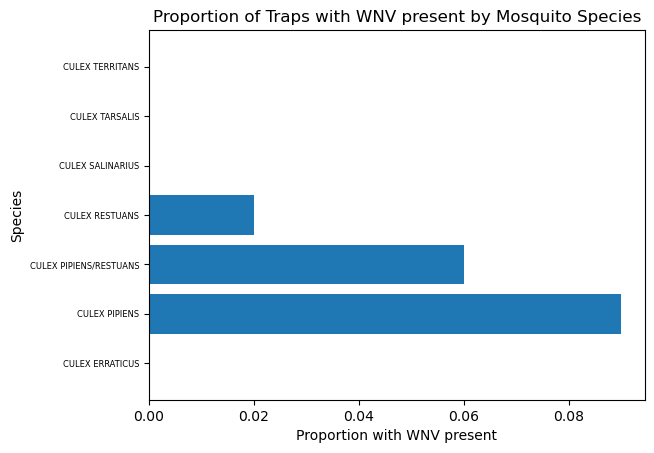

In [24]:
# Proportion of each species caught with the West Nile Virus
proportions = []
for i in range(len(list(train.groupby('Species')['WnvPresent'].sum()))):
    proportions.append(round(list(train.groupby('Species')['WnvPresent'].sum())[i] / list(train.groupby('Species')['Species'].count())[i], 2))

plt.barh(train.groupby('Species')['WnvPresent'].sum().index.tolist(), proportions)
plt.title("Proportion of Traps with WNV present by Mosquito Species")
plt.xlabel("Proportion with WNV present")
plt.ylabel("Species")
plt.yticks(fontsize=6);

We note that there is an 'UNSPECIFIED CULEX' in the test dataset - a factor level never encountered before in our dataset. There are 2 approaches going forward:

(1) Prescribe the majority class 'CULEX PIPIENS/RESTUANS', which account for >99% observations (together with CULEX PIPIENS + CULEX RESTUANS) in the train set. **This is the approach we will adopt**.\
(2) Train the model without using species variable. However, we lose information this way.

In [25]:
train['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'CULEX ERRATICUS'], dtype=object)

In [26]:
test['Species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [27]:
# Actual code to replace 'UNSPECIFIED CULEX' with 'CULEX PIPIENS/RESTUANS'
test = test.replace('UNSPECIFIED CULEX','CULEX PIPIENS/RESTUANS')

### (ii) Weather Dataset

In [28]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,0448,1849,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,0447,1850,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,0446,1851,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9


We scan the weather dataset to get a better sense of how we can process the data:

(1) **Heat and Cool are Irrelevant** These data are calculated based on 'Tavg' - 65. We can rely on Tavg alone for this information.\
(2) **Depth and Water1 can be removed** Since the values are only 0 or M(issing). There is not enough variance for it to be meaningful. \
(3) **Depart can be Removed** The column measures [the difference between the average temperature for the day against the 30 years average temperature.](https://ipad.fas.usda.gov/cropexplorer/description.aspx?legendid=204) I opine this data to be irrelevant to our analysis.


In [29]:
# The void that is Water1
weather['Water1'].value_counts()

M    2944
Name: Water1, dtype: int64

In [30]:
# The void that is Depth
weather['Depth'].value_counts()

0    1472
M    1472
Name: Depth, dtype: int64

In [31]:
weather.drop(columns = ['Heat', 'Cool','Depth','Water1','Depart'], inplace = True)

(4) **Sunrise and SunSet Can be Converted into Daylight Hours** This is streamlined the 2 columns into 1 single numerical variable. The data should also be the same for Station 1 and Station 2 on any given day. We tailor a function to convert said two columns into single column - number of daylight hours.

In [32]:
def sunshine_maker(sunrise, sunset):
    
    # Obtain Sunrise Hours and Mins
    if sunrise[0] == '0':
        if sunrise[1] == '0':
            sunrise_hr = 0
        else:
            sunrise_hr = int(sunrise[1])
    else:
        sunrise_hr = int(sunrise[0:2])
            
    if sunrise[2] == '0':
        if sunrise[3] == '0':
            sunrise_min = 0
        else:
            sunrise_min = int(sunrise[3])
    else:
        sunrise_min = int(sunrise[2:4])  
    
    # Obtain Sunset Hours and Mins
    if sunset[0] == '0':
        if sunset[1] == '0':
            sunset_hr = 0
        else:
            sunset_hr = int(sunset[1])
    else:
        sunset_hr = int(sunset[0:2])
            
    if sunset[2] == '0':
        if sunset[3] == '0':
            sunset_min = 0
        else:
            sunset_min = int(sunset[3])
    else:
        sunset_min = int(sunset[2:4]) 
    
    
    # Find Delta
    if sunrise_min > sunset_min:
        sun_min = sunset_min + 60 - sunrise_min
        sun_hr = sunset_hr - sunrise_hr - 1
        
    else:
        sun_min = sunset_min - sunrise_min
        sun_hr = sunset_hr - sunrise_hr
        
    return(sun_hr + sun_min/60)

After creating the function, we apply it to only station 1 data (since the Sunrise and Sunset info are missing for station 2).

In [33]:
# Obtain subset of weather data for weather station 1
weather_station_1 = weather[weather['Station'] == 1]

In [34]:
# Implement function to calculate daylight hours for subsetted data
weather_station_1['Sunlight'] = weather_station_1.progress_apply(lambda row: sunshine_maker(row['Sunrise'], row['Sunset']), axis = 1)

100%|█████████████████████████████████████| 1472/1472 [00:00<00:00, 154431.46it/s]
/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/2192819578.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_station_1['Sunlight'] = weather_station_1.progress_apply(lambda row: sunshine_maker(row['Sunrise'], row['Sunset']), axis = 1)


In [35]:
# We obtain a similar subset of weather_station 2 points
weather_station_2 = weather[weather['Station'] == 2]

In [36]:
## We reset both indexes so that the merge can pick up the corresponding values
## Original index is stored in a new column with drop = False
weather_station_1.reset_index(drop = False, inplace = True)
weather_station_2.reset_index(drop = False, inplace = True)

In [37]:
# For weather station 2, we just need to copy the 'Sunlight' column from weather_station_1 directly
weather_station_2['Sunlight'] = weather_station_1['Sunlight']

/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/3745807853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_station_2['Sunlight'] = weather_station_1['Sunlight']


In [38]:
# Now we remerge the 2 dataframes
weather = pd.concat([weather_station_1, weather_station_2], axis = 0)

In [39]:
# We reset the index with of the combined dataframe with the original index
weather.set_index('index',inplace = True)

In [40]:
# We perform a sort by the index to return the data to its original sequence
weather.sort_index(inplace = True)

In [41]:
# Finally, we proceeed to drop off the Sunrise and Sunset Columns
weather.drop(columns = ['Sunrise', 'Sunset'], inplace = True)

In [42]:
# Here we see a new sunlight hours column
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight
index,,,,,,,,,,,,,,,,
0,1,2007-05-01,83,50,67,51,56,,0.0,0.00,29.10,29.82,1.7,27,9.2,14.016667
1,2,2007-05-01,84,52,68,51,57,,M,0.00,29.18,29.82,2.7,25,9.6,14.016667
2,1,2007-05-02,59,42,51,42,47,BR,0.0,0.00,29.38,30.09,13.0,4,13.4,14.050000
3,2,2007-05-02,60,43,52,42,47,BR HZ,M,0.00,29.44,30.08,13.3,2,13.4,14.050000
4,1,2007-05-03,66,46,56,40,48,,0.0,0.00,29.39,30.12,11.7,7,11.9,14.083333


(5) **Snowfall can be removed** >99% of datapoints are M or 0.0. Indeed, the mosquito threat is a summer sort-of-thing, and the snowfall measure (i.e. winter) is irrelevant here.

In [43]:
weather['SnowFall'].value_counts()

M      1472
0.0    1459
  T      12
0.1       1
Name: SnowFall, dtype: int64

In [44]:
weather.drop(columns = ['SnowFall'], inplace =True)

In [45]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight
index,,,,,,,,,,,,,,,
0,1,2007-05-01,83,50,67,51,56,,0.00,29.10,29.82,1.7,27,9.2,14.016667
1,2,2007-05-01,84,52,68,51,57,,0.00,29.18,29.82,2.7,25,9.6,14.016667
2,1,2007-05-02,59,42,51,42,47,BR,0.00,29.38,30.09,13.0,4,13.4,14.050000
3,2,2007-05-02,60,43,52,42,47,BR HZ,0.00,29.44,30.08,13.3,2,13.4,14.050000
4,1,2007-05-03,66,46,56,40,48,,0.00,29.39,30.12,11.7,7,11.9,14.083333


(6) **CodeSum Column Can Be Engineered into a new feature** This column provides great details into the actual weather conditions. There is a large amount of designation for CodeSum variables, for the many types of special weather conditions. We will attempt to classify them into more manageable number of classes, and characterise each observation accordingly.

In [46]:
set(weather['CodeSum'].str.split().sum())

{'BCFG',
 'BR',
 'DZ',
 'FG',
 'FG+',
 'FU',
 'GR',
 'HZ',
 'MIFG',
 'RA',
 'SN',
 'SQ',
 'TS',
 'TSRA',
 'VCFG',
 'VCTS'}

In [47]:
weather['CodeSum'] = weather['CodeSum'].str.split()

In [48]:
# First we obtain a unique list of special weather conditions that lies inside the CodeSum column
list_of_conditions = ['MIFG','TS','SQ','GR','VCFG','FG+','SN','FG','VCTS','BCFG','BR','RA','FU','DZ','TSRA','HZ']

We note the following meaning for these acronyms:
- **DZ**: Drizzle
- **RA**: Rain
- **BCFG**: Patches, Fog
- **SQ**: Squall
- **SN**: Snow
- **TSRA**: Thunderstorm Rain
- **VCTS**: Vicinity Thunderstorm
- **GR**: Hail
- **MIFG**: Shallow Fog
- **VCFG**: Vicinity Fog
- **BR**: Mist
- **HZ**: Haze
- **FG+**: Heavy Fog
- **TS**: Thunderstorm
- **FG**: Fog
- **FU**: Smoke

We will create new columns for all of these weather conditions in the weather dataset

In [49]:
# First we create columns of zeros for the weather conditions
for condition in list_of_conditions:
    weather[condition] = 0

In [50]:
# Then we fill in the value with 1 with a certain weather condition exist
for condition in list_of_conditions:
    weather[condition] = weather.progress_apply(lambda row: 1 if (condition in row['CodeSum']) else 0, axis = 1)

100%|█████████████████████████████████████| 2944/2944 [00:00<00:00, 236163.24it/s]


In [51]:
# Now we can remove CodeSum column
weather.drop(columns = ['CodeSum'], inplace = True)

## (5) Removing Correlated Weather Data 

Following the previous section, we end up with a more compact weather dataset. To streamline the dataset further, we further examine the variables for multi-collinearity. But before that, we have quite a few missing data to contend with.

#### (i) Tavg (Recompute from Tmax and Tmin)

In [52]:
# we note some 'M' values to be missing - but small matter, we can compute them using info form Tmax and Tmin
weather['Tavg'].unique()

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [53]:
# recompute tavg column
weather['Tavg'] = weather.progress_apply(lambda row: (row['Tmax'] + row['Tmin'])/2, axis =1)

100%|█████████████████████████████████████| 2944/2944 [00:00<00:00, 183324.89it/s]


#### (ii) WetBulb (Get Data from alternate Weather Station)

In [54]:
# we note some 'M' data for WetBulb
weather['WetBulb'].unique()

array(['56', '57', '47', '48', '50', '49', '46', '54', '53', '62', '63',
       '60', '61', '51', '59', '58', '43', '44', '45', '65', '66', '67',
       '64', '52', '55', '69', '68', '70', '72', '71', '73', '74', '76',
       '42', '39', '40', '41', '35', '33', '34', 'M', '75', '36', '32',
       '38', '78', '77', '37'], dtype=object)

In [55]:
# We tap data from the weather station to patch these missing values
# Best we can make do in the absence of perfect information
weather.iloc[[849,2411,2413,2414],:]

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
849,2,2009-06-26,86,72,79.0,61,67,0.00,29.20,29.83,6.4,4,8.0,15.216667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2411,2,2013-08-10,81,68,74.5,55,63,0.00,M,30.07,6.0,6,7.4,14.100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2413,2,2013-08-11,84,63,73.5,57,64,T,29.42,30.06,4.0,24,5.4,14.066667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2414,1,2013-08-12,82,67,74.5,65,68,0.27,29.21,29.93,3.5,27,7.5,14.033333,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [56]:
# Insert corresponding data from other weather station into missing values
weather.at[848, 'WetBulb'] = 67
weather.at[2410, 'WetBulb'] = 63
weather.at[2412, 'WetBulb'] = 64
weather.at[2415, 'WetBulb'] = 68

In [57]:
# Convert WetBulb to Numeric values
weather['WetBulb'] = pd.to_numeric(weather['WetBulb'])

#### (iii) PrecipTotal (Treat "Trace" amount as 0 + Get Data from alternate Weather Station)

In [58]:
# We note '  T' (trace) and 'M' (missing values) in the datasets
weather['PrecipTotal'].unique()

array(['0.00', '  T', '0.13', '0.02', '0.38', '0.60', '0.14', '0.07',
       '0.11', '0.09', '1.01', '0.28', '0.04', '0.08', '0.01', '0.53',
       '0.19', '0.21', '0.32', '0.39', '0.31', '0.42', '0.27', '0.16',
       '0.58', '0.93', '0.05', '0.34', '0.15', '0.35', 'M', '0.40',
       '0.66', '0.30', '0.24', '0.43', '1.55', '0.92', '0.89', '0.17',
       '0.03', '1.43', '0.97', '0.26', '1.31', '0.06', '0.46', '0.29',
       '0.23', '0.41', '0.45', '0.83', '1.33', '0.91', '0.48', '0.37',
       '0.88', '2.35', '1.96', '0.20', '0.25', '0.18', '0.67', '0.36',
       '0.33', '1.28', '0.74', '0.76', '0.71', '0.95', '1.46', '0.12',
       '0.52', '0.64', '0.22', '1.24', '0.72', '0.73', '0.65', '1.61',
       '1.22', '0.50', '1.05', '2.43', '0.59', '2.90', '2.68', '1.23',
       '0.62', '6.64', '3.07', '1.44', '1.75', '0.82', '0.80', '0.86',
       '0.63', '0.55', '1.03', '0.70', '1.73', '1.38', '0.44', '1.14',
       '1.07', '3.97', '0.87', '0.78', '1.12', '0.68', '0.10', '0.61',
       '0.

In [59]:
# We convert all '  T' to zero, since trace suggest an insignificant volume
index_of_T_Precip = weather[weather['PrecipTotal'] == '  T'].index
for index in index_of_T_Precip:
    weather.at[index, 'PrecipTotal'] = 0

In [60]:
# We tackle missing value next by replacing them with data from the other weather station
weather[weather['PrecipTotal'] == 'M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
117,2,2007-06-28,73,61,67.0,56,61,M,29.43,30.07,12.2,2,13.3,15.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
119,2,2007-06-29,71,56,63.5,56,60,M,29.47,30.11,7.4,2,8.2,15.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [61]:
# perform replacement
weather.at[117, 'PrecipTotal'] = weather.at[116, 'PrecipTotal']
weather.at[119, 'PrecipTotal'] = weather.at[118, 'PrecipTotal']

In [62]:
# Convert PrecipTotal to Numeric values
weather['PrecipTotal'] = pd.to_numeric(weather['PrecipTotal'])

#### (iv) StnPressure (Get Data from alternate Weather Station + extrapolate from previous and next day data)

In [63]:
# We note 'M' (missing values) in the datasets
weather['StnPressure'].unique()

array(['29.10', '29.18', '29.38', '29.44', '29.39', '29.46', '29.31',
       '29.36', '29.40', '29.57', '29.62', '29.29', '29.21', '29.28',
       '29.20', '29.26', '29.33', '29.49', '29.54', '29.55', '29.23',
       '29.13', '29.19', '29.53', '29.60', '29.34', '29.41', '29.47',
       '29.51', '29.42', '29.43', '29.25', '29.03', '28.82', '28.87',
       '28.88', '29.16', '29.07', '28.84', '28.91', '29.24', 'M', '29.30',
       '29.12', '29.45', '29.56', '29.32', '29.05', '29.11', '29.06',
       '29.22', '29.08', '29.14', '29.37', '29.35', '29.15', '29.17',
       '29.48', '29.52', '29.27', '29.50', '28.59', '28.67', '28.75',
       '29.02', '29.79', '29.86', '29.63', '29.70', '28.95', '29.01',
       '28.79', '28.85', '28.97', '28.89', '28.94', '28.93', '28.98',
       '28.96', '29.00', '29.66', '29.09', '28.90', '29.04', '29.59',
       '29.65', '29.58', '29.61', '29.64', '29.71', '29.67', '28.80',
       '28.73', '29.68', '28.74', '28.55', '28.63', '28.92', '28.99',
       '28.81',

In [64]:
# we examined the 'M' data
weather[weather['StnPressure'] == 'M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87,2,2007-06-13,86,68,77.0,53,62,0.0,M,M,7.0,5,M,15.183333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
848,1,2009-06-26,86,69,77.5,60,67,0.0,M,29.85,6.4,4,8.2,15.216667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2410,1,2013-08-10,81,64,72.5,57,63,0.0,M,30.08,5.3,5,6.5,14.100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2411,2,2013-08-10,81,68,74.5,55,63,0.0,M,30.07,6.0,6,7.4,14.100000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
# For the first 2, we replace them with data from the neighbouring weatehr station
weather.at[87, 'StnPressure'] = weather.at[86, 'StnPressure']
weather.at[848, 'StnPressure'] = weather.at[849, 'StnPressure']
# For the other two, we will take the average of the pressure from one day before and one day after
# This is with the assumption that pressure should not differ too strongly on a day to day basis
weather.at[2410, 'StnPressure'] = (float(weather.at[2408, 'StnPressure']) + float(weather.at[2412, 'StnPressure']))/2
weather.at[2411, 'StnPressure'] = (float(weather.at[2409, 'StnPressure']) + float(weather.at[2413, 'StnPressure']))/2

In [66]:
# Convert StnPressure to Numeric values
weather['StnPressure'] = pd.to_numeric(weather['StnPressure'])

#### (v) SeaLevel (Get Data from alternate Weather Station)

In [67]:
# We note some 'M' values
weather['SeaLevel'].unique()

array(['29.82', '30.09', '30.08', '30.12', '30.05', '30.04', '30.10',
       '30.29', '30.28', '30.03', '30.02', '29.94', '29.93', '29.92',
       '29.91', '30.20', '30.19', '30.24', '29.97', '29.98', '29.84',
       '29.83', '30.27', '30.25', '30.26', '30.11', '30.06', '30.23',
       '30.15', '30.14', '30.00', '29.99', '29.90', '29.77', '29.76',
       '29.56', '29.54', '29.52', '29.51', '29.79', '29.78', '29.81',
       '29.55', '29.85', '30.07', '30.16', 'M', '29.96', '29.95', '30.13',
       '30.21', '30.22', '29.88', '30.01', '29.80', '29.89', '29.74',
       '29.87', '29.86', '30.18', '30.17', '29.34', '29.44', '29.45',
       '29.71', '29.72', '30.52', '30.53', '30.40', '30.41', '29.67',
       '29.53', '29.69', '29.61', '29.64', '29.63', '29.66', '29.70',
       '30.34', '30.33', '29.62', '29.60', '29.75', '29.68', '29.73',
       '30.31', '30.30', '30.32', '30.37', '30.39', '29.59', '29.65',
       '30.35', '30.36', '29.48', '30.38', '29.50', '29.25', '29.23',
       '29.46',

In [68]:
# Examining the missing data
weather[weather['SeaLevel'] == 'M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87,2,2007-06-13,86,68,77.0,53,62,0.00,29.36,M,7.0,5,M,15.183333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
832,1,2009-06-18,80,61,70.5,63,67,0.12,29.08,M,6.7,16,7.9,15.216667,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
994,1,2009-09-07,77,59,68.0,59,62,0.00,29.39,M,5.8,3,4.0,12.900000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1732,1,2011-09-08,75,57,66.0,53,59,0.00,29.34,M,13.0,2,13.4,12.850000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1745,2,2011-09-14,60,48,54.0,45,51,0.00,29.47,M,6.0,32,M,12.583333,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1
1756,1,2011-09-20,74,49,61.5,54,58,0.00,29.26,M,7.3,18,7.3,12.266667,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2067,2,2012-08-22,84,72,78.0,51,61,0.00,29.39,M,4.7,19,M,13.616667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2090,1,2012-09-03,88,71,79.5,70,73,0.00,29.17,M,4.6,6,4.4,13.083333,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2743,2,2014-07-23,76,64,70.0,56,61,0.00,29.47,M,16.4,2,16.7,14.733333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# We tap on the SeaLevel of the neighbouring weather station for the missing data
weather.at[87, 'SeaLevel'] = weather.at[86, 'SeaLevel']
weather.at[832, 'SeaLevel'] = weather.at[833, 'SeaLevel']
weather.at[994, 'SeaLevel'] = weather.at[995, 'SeaLevel']
weather.at[1732, 'SeaLevel'] = weather.at[1733, 'SeaLevel']
weather.at[1745, 'SeaLevel'] = weather.at[1744, 'SeaLevel']
weather.at[1756, 'SeaLevel'] = weather.at[1757, 'SeaLevel']
weather.at[2067, 'SeaLevel'] = weather.at[2066, 'SeaLevel']
weather.at[2090, 'SeaLevel'] = weather.at[2091, 'SeaLevel']
weather.at[2743, 'SeaLevel'] = weather.at[2742, 'SeaLevel']

In [70]:
# Convert StnPressure to Numeric values
weather['SeaLevel'] = pd.to_numeric(weather['SeaLevel'])

#### (vi) AvgSpeed (Get Data from alternate Weather Station)

In [71]:
# We note missing 'M' Values for Average Speed
weather['AvgSpeed'].unique()

array(['9.2', '9.6', '13.4', '11.9', '13.2', '10.8', '10.4', '12.0',
       '11.5', '15.0', '14.5', '10.5', '9.9', '5.8', '5.4', '6.2', '5.9',
       '4.1', '3.9', '12.9', '12.8', '13.0', '8.1', '7.6', '17.3', '14.6',
       '12.3', '12.2', '11.8', '11.3', '7.5', '5.5', '11.4', '10.7',
       '9.7', '8.2', '7.8', '10.2', '10.6', '11.2', '15.2', '8.8', '7.2',
       '9.5', '5.3', '5.2', '6.5', '7.4', '10.1', '6.4', '6.7', '23.1',
       '20.7', '13.8', '12.4', '5.0', '4.7', '5.6', '6.9', '8.4', '10.0',
       '8.6', 'M', '6.8', '4.9', '6.1', '6.3', '15.1', '12.6', '7.7',
       '8.7', '9.0', '8.0', '6.0', '7.1', '8.5', '12.5', '13.3', '8.3',
       '7.3', '13.1', '12.7', '10.9', '11.1', '13.9', '6.6', '14.4',
       '9.1', '3.3', '3.5', '4.0', '7.0', '9.4', '7.9', '5.7', '4.3',
       '4.6', '3.7', '11.7', '4.4', '12.1', '13.5', '13.7', '11.0', '9.8',
       '8.9', '10.3', '15.5', '18.9', '17.2', '16.7', '18.0', '18.2',
       '16.8', '14.1', '14.7', '4.2', '9.3', '14.3', '17.7', '17.8'

In [72]:
# Examining the missing data
weather[weather['AvgSpeed'] == 'M']

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
87,2,2007-06-13,86,68,77.0,53,62,0.0,29.36,30.09,7.0,5,M,15.183333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1745,2,2011-09-14,60,48,54.0,45,51,0.0,29.47,30.09,6.0,32,M,12.583333,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1
2067,2,2012-08-22,84,72,78.0,51,61,0.0,29.39,30.07,4.7,19,M,13.616667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [73]:
# Tap on neighbouring weather station for missing data
weather.at[87, 'AvgSpeed'] = weather.at[86, 'AvgSpeed']
weather.at[1745, 'AvgSpeed'] = weather.at[1744, 'AvgSpeed']
weather.at[2067, 'AvgSpeed'] = weather.at[2066, 'AvgSpeed']

In [74]:
# Convert StnPressure to Numeric values
weather['AvgSpeed'] = pd.to_numeric(weather['AvgSpeed'])

In [75]:
weather.head()

,Station,Date,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,2007-05-01,83,50,66.5,51,56,0.0,29.10,29.82,1.7,27,9.2,14.016667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2007-05-01,84,52,68.0,51,57,0.0,29.18,29.82,2.7,25,9.6,14.016667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2007-05-02,59,42,50.5,42,47,0.0,29.38,30.09,13.0,4,13.4,14.050000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2,2007-05-02,60,43,51.5,42,47,0.0,29.44,30.08,13.3,2,13.4,14.050000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1,2007-05-03,66,46,56.0,40,48,0.0,29.39,30.12,11.7,7,11.9,14.083333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Now We Are Ready to Remove Correlated Weather Data

Inspecting the correlation chart, we identify 3 main correalted clusters:\
(1) **Tmax, Tmin, Tavg, DewPoint, and WetBulb**: We will keep Tavg and drop the rest\
(2) **StnPressure and SeaLevel**: We will keep StnPressure and drop the SeaLevel\
(3) **ResultSpeed and AvgSpeed**: We will keep AvgSpeed and drop the rest

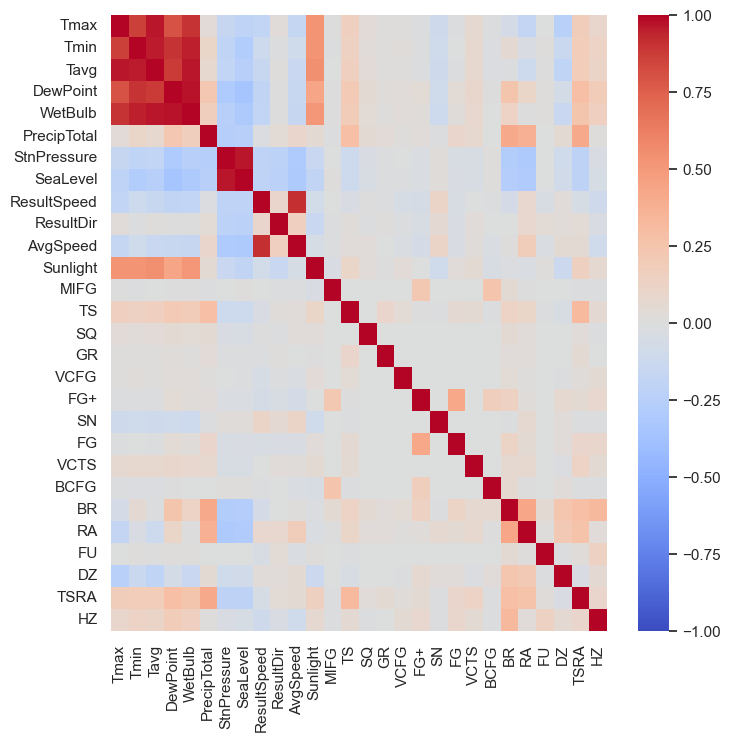

In [76]:
## Examine correlation
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(weather.drop(columns = ['Station', 'Date']).corr(), vmin=-1, vmax =1, cmap = 'coolwarm');

We drop 'Tmax','Tmin','DewPoint','WetBulb','SeaLevel','ResultSpeed' - our others highlly correlated factors.

In [77]:
## Drop Correlated Variables
weather.drop(columns = ['Tmax','Tmin','DewPoint','WetBulb','SeaLevel','ResultSpeed'], axis = 1, inplace = True)

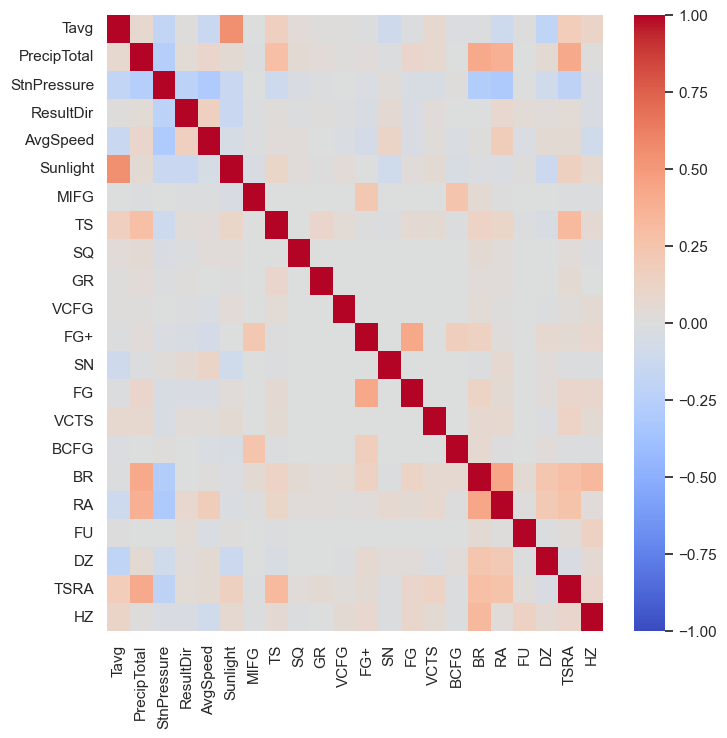

In [78]:
## Re-Examine correlation - Much Better
sns.heatmap(weather.drop(columns = ['Station', 'Date']).corr(), vmin=-1, vmax =1, cmap = 'coolwarm');

## (6) On Weather Information by both Weather Stations

We have two weather stations providing two disparate set of weather information. We need a systematic approach to decide how should the weather conditions surrounding a trap be determined. We propose a weighted approach whereby the relative weightage for each weather station is calculated as the inverse-squared-distance of a trap from each weather station. The pair of weights for each trap is then normalised against each other, and the relative proportion of the data drawn from each weather station's data point.

To begin, we first measure the distance of each trap from each weather station.

In [79]:
# Get list of weather stations, from both train and test data sets
# We also get the lat and long, which we will need for distance calculation

train_traps = train[['Trap','Latitude','Longitude']]
test_traps = test[['Trap','Latitude','Longitude']]

In [80]:
# We notice that there are 3 traps with different coordinates, thus resulting in duplicate copies
# We change the value to adopt the former to be consistent

In [81]:
# We remove duplicates
train_traps.drop_duplicates(inplace = True, ignore_index= True)
test_traps.drop_duplicates(inplace = True, ignore_index= True)

/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/23061768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_traps.drop_duplicates(inplace = True, ignore_index= True)
/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/23061768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_traps.drop_duplicates(inplace = True, ignore_index= True)


In [82]:
# We have about ~300 distances to calculate
print(test_traps.shape, train_traps.shape)

(151, 3) (138, 3)


In [83]:
# Develop a function to calculate distance
# We also note the Lat long of the weather stations
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

def distance_weight_maker (latitude, longitude):
    distance_to_1 = geopy.distance.geodesic((41.995,-87.933), (latitude, longitude)).km
    distance_to_2 = geopy.distance.geodesic((41.786,-87.752), (latitude, longitude)).km
    
    inverse_distance_square_to_1 = 1/(distance_to_1**2)
    inverse_distance_square_to_2 = 1/(distance_to_2**2)
    
    weight_1 = inverse_distance_square_to_1 / (inverse_distance_square_to_1 + inverse_distance_square_to_2)
    weight_2 = inverse_distance_square_to_2 / (inverse_distance_square_to_1 + inverse_distance_square_to_2)
    
    return (weight_1, weight_2)

In [84]:
# Using the function, we calculate the said weights for each trap
train_traps['weight_1'] = train_traps.progress_apply(lambda row: distance_weight_maker(row['Latitude'],
                                                                                      row['Longitude'])[0],
                                                     axis = 1)
train_traps['weight_2'] = train_traps.progress_apply(lambda row: distance_weight_maker(row['Latitude'],
                                                                                      row['Longitude'])[1],
                                                     axis = 1)

test_traps['weight_1'] = test_traps.progress_apply(lambda row: distance_weight_maker(row['Latitude'],
                                                                                      row['Longitude'])[0],
                                                     axis = 1)
test_traps['weight_2'] = test_traps.progress_apply(lambda row: distance_weight_maker(row['Latitude'],
                                                                                      row['Longitude'])[1],
                                                     axis = 1)

100%|█████████████████████████████████████████| 138/138 [00:00<00:00, 4975.83it/s]
/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/30860993.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_traps['weight_1'] = train_traps.progress_apply(lambda row: distance_weight_maker(row['Latitude'],
100%|█████████████████████████████████████████| 138/138 [00:00<00:00, 5143.09it/s]
/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/30860993.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

Finally we notice duplicate rows appearing because of the way we have managed our satellites traps previously. We will remove the duplicate rows (marking the coordinates of the original satellite traps location). As discussed, all satellites are in proximity to their parent traps and we expect this treatment to have minimal impact to our study. Of note, this step is necessary to facilitate the next step of our pre-preprocessing.

In [85]:
# Duplicate traps (Originally satellite traps) in train_traps
train_traps['Trap'].value_counts()[0:5]

T009    2
T094    2
T035    2
T054    2
T077    1
Name: Trap, dtype: int64

In [86]:
train_traps[train_traps['Trap'].isin(['T009', 'T094', 'T035','T054'])]

,Trap,Latitude,Longitude,weight_1,weight_2
8,T054,41.921965,-87.632085,0.322258,0.677742
11,T094,41.720848,-87.666014,0.067999,0.932001
18,T009,41.981964,-87.812827,0.831371,0.168629
71,T035,41.836644,-87.677737,0.084251,0.915749
116,T009,41.992478,-87.862995,0.947676,0.052324
129,T035,41.763733,-87.742302,0.007378,0.992622
136,T094,41.719140,-87.669539,0.067245,0.932755
137,T054,41.925652,-87.633590,0.333037,0.666963


In [87]:
# Remove duplicate / satellite trap rows
train_traps.drop([116,129,136,137], inplace = True)
train_traps['Trap'].value_counts()[0:3]

/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/768001050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_traps.drop([116,129,136,137], inplace = True)


T002    1
T074    1
T200    1
Name: Trap, dtype: int64

In [88]:
# Duplicate traps (originally satellite traps) in tests_traps
test_traps['Trap'].value_counts()[0:12]

T218    4
T090    4
T002    3
T200    3
T094    2
T005    2
T065    2
T128    2
T009    2
T035    2
T054    2
T230    1
Name: Trap, dtype: int64

In [89]:
test_traps[test_traps['Trap'].isin(['T218', 'T090', 'T002','T200','T094','T005',
                                     'T065', 'T128', 'T009', 'T035', 'T054'
                                     ])]

,Trap,Latitude,Longitude,weight_1,weight_2
0,T002,41.954690,-87.800991,0.724535,0.275465
8,T054,41.921965,-87.632085,0.322258,0.677742
11,T094,41.720848,-87.666014,0.067999,0.932001
18,T009,41.981964,-87.812827,0.831371,0.168629
27,T090,41.868077,-87.666901,0.162514,0.837486
42,T218,41.948167,-87.730698,0.515197,0.484803
66,T005,41.942114,-87.776385,0.600161,0.399839
71,T035,41.836644,-87.677737,0.084251,0.915749
77,T065,41.778297,-87.752411,0.000911,0.999089
98,T200,41.678618,-87.559308,0.153703,0.846297


In [90]:
# Remove satellite traps (Note: every first instance of a trap is the parent, which we will keep)
test_traps.drop([125,126,127,119,120,121,140,141,122,124,149,143,148,123,116,137,150], inplace = True)

/var/folders/74/97wv04ds7nd2hspvzx_sngrm0000gn/T/ipykernel_24426/3111690831.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_traps.drop([125,126,127,119,120,121,140,141,122,124,149,143,148,123,116,137,150], inplace = True)


## (7) Export Datasets for Further Modelling

In [91]:
train.to_csv('./assets/Processed Data/train_cleaned.csv')
test.to_csv('./assets/Processed Data/test_cleaned.csv')
spray.to_csv('./assets/Processed Data/spray_cleaned.csv')
weather.to_csv('./assets/Processed Data/weather_cleaned.csv')

train_traps.to_csv('./assets/Processed Data/train_traps.csv')
test_traps.to_csv('./assets/Processed Data/test_traps.csv')

In [93]:
weather.head()

,Station,Date,Tavg,PrecipTotal,StnPressure,ResultDir,AvgSpeed,Sunlight,MIFG,TS,SQ,GR,VCFG,FG+,SN,FG,VCTS,BCFG,BR,RA,FU,DZ,TSRA,HZ
index,,,,,,,,,,,,,,,,,,,,,,,,
0,1,2007-05-01,66.5,0.0,29.10,27,9.2,14.016667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,2007-05-01,68.0,0.0,29.18,25,9.6,14.016667,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2007-05-02,50.5,0.0,29.38,4,13.4,14.050000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2,2007-05-02,51.5,0.0,29.44,2,13.4,14.050000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
4,1,2007-05-03,56.0,0.0,29.39,7,11.9,14.083333,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
